<a href="https://colab.research.google.com/github/digantkumar/Digant-Kumar/blob/master/Task%202%20-%20Denoising%20Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TASK 2 - AUTOENCODER DENOISING**

In [0]:
# Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### **AUTOENCODER BASE MODEL (GIVEN)**

In [0]:
#################################################################################################
#########                        Autoencoder Base Model                                  ########
#################################################################################################

# Encoder function to learn a compressed data structure
class Encoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim):
        super(Encoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
    
    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return self.output_layer(activation)

In [0]:
# Decoder function to reconstruct the data from lower dimension to its higher dimension
class Decoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim, original_dim):
        super(Decoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=original_dim, activation=tf.nn.relu)
  
    def call(self, code):
        activation = self.hidden_layer(code)
        return self.output_layer(activation)

In [0]:
# Combines both the encoder and decoder and generates the output
class Autoencoder(tf.keras.Model):
  def __init__(self, intermediate_dim, original_dim):
    super(Autoencoder, self).__init__()
    self.loss = []
    self.encoder = Encoder(intermediate_dim=intermediate_dim)
    self.decoder = Decoder(intermediate_dim=intermediate_dim, original_dim=original_dim)

  def call(self, input_features):
    code = self.encoder(input_features)
    reconstructed = self.decoder(code)
    return reconstructed

In [0]:
def loss(preds, real):
  return tf.reduce_mean(tf.square(tf.subtract(preds, real)))

In [0]:
def train(loss, model, opt, original):
  with tf.GradientTape() as tape:
    preds = model(original)
    reconstruction_error = loss(preds, original)
  gradients = tape.gradient(reconstruction_error, model.trainable_variables)
  gradient_variables = zip(gradients, model.trainable_variables)
  opt.apply_gradients(gradient_variables)
  
  return reconstruction_error

In [0]:
def train_loop(model, opt, loss, dataset, epochs):
  for epoch in range(epochs):
    epoch_loss = 0
    for step, batch_features in enumerate(dataset):
      loss_values = train(loss, model, opt, batch_features)
      epoch_loss += loss_values
    model.loss.append(epoch_loss)
    print('Epoch {}/{}. Loss: {}'.format(epoch + 1, epochs, epoch_loss.numpy()))

In [0]:
# Importing the mnist dataset
from keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test, (x_test.shape[0], 784))

# Introducing noise with a probability factor of 0.5
noise_factor = 0.5
x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Reshaping the noise into 784 pixels (28*28)
x_train_noisy = np.reshape(x_train_noisy, (x_train_noisy.shape[0], 784))
x_test_noisy = np.reshape(x_test_noisy, (x_test_noisy.shape[0], 784))
x_train_noisy = x_train_noisy.astype('float32')
x_test_noisy = x_test_noisy.astype('float32')
training_dataset = tf.data.Dataset.from_tensor_slices(x_train_noisy).batch(256)

In [0]:
model = Autoencoder(intermediate_dim=128, original_dim=784)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

train_loop(model, opt, loss, training_dataset, 100)

Epoch 1/100. Loss: 125.59982299804688
Epoch 2/100. Loss: 46.8834228515625
Epoch 3/100. Loss: 46.60837173461914
Epoch 4/100. Loss: 46.37431716918945
Epoch 5/100. Loss: 46.17355728149414
Epoch 6/100. Loss: 45.85505294799805
Epoch 7/100. Loss: 45.65891647338867
Epoch 8/100. Loss: 45.54412841796875
Epoch 9/100. Loss: 45.52465057373047
Epoch 10/100. Loss: 45.51613235473633
Epoch 11/100. Loss: 45.45962905883789
Epoch 12/100. Loss: 45.37454605102539
Epoch 13/100. Loss: 45.215824127197266
Epoch 14/100. Loss: 45.2021369934082
Epoch 15/100. Loss: 45.19440460205078
Epoch 16/100. Loss: 45.191810607910156
Epoch 17/100. Loss: 45.18891143798828
Epoch 18/100. Loss: 45.18735885620117
Epoch 19/100. Loss: 45.10048294067383
Epoch 20/100. Loss: 45.025001525878906
Epoch 21/100. Loss: 44.978309631347656
Epoch 22/100. Loss: 44.890140533447266
Epoch 23/100. Loss: 44.82794189453125
Epoch 24/100. Loss: 44.82618713378906
Epoch 25/100. Loss: 44.80246353149414
Epoch 26/100. Loss: 44.671775817871094
Epoch 27/100. Lo

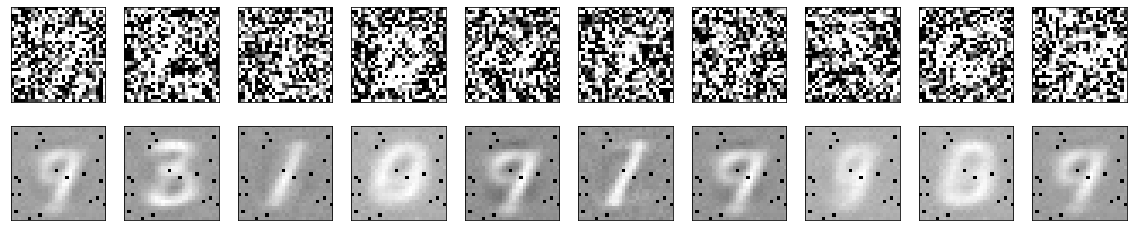

In [0]:
number = 10 
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test_noisy[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(x_test_noisy)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### **AUTOENCODER OPTIMIZED MODEL**

In [0]:
#################################################################################################
#########                     Autoencoder Optimized Model                                ########
#################################################################################################

# Encoder function to learn a compressed data structure
class Encoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim):
        super(Encoder, self).__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=intermediate_dim/2, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=intermediate_dim/2, activation=tf.nn.sigmoid)
    
    def call(self, input_features):
        hid_layer_1 = self.hidden_layer_1(input_features)
        activation = self.hidden_layer_2(hid_layer_1)
        return self.output_layer(activation)

In [0]:
# Decoder function to reconstruct the data from lower dimension to its higher dimension
class Decoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim, original_dim):
        super(Decoder, self).__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=original_dim, activation=tf.nn.sigmoid)
  
    def call(self, code):
        activation = self.hidden_layer_1(code)
        return self.output_layer(activation)

In [0]:
# Combines both the encoder and decoder and generates the output
class Autoencoder(tf.keras.Model):
  def __init__(self, intermediate_dim, original_dim):
    super(Autoencoder, self).__init__()
    self.loss = []
    self.encoder = Encoder(intermediate_dim=intermediate_dim)
    self.decoder = Decoder(intermediate_dim=intermediate_dim, original_dim=original_dim)

  def call(self, input_features):
    code = self.encoder(input_features)
    reconstructed = self.decoder(code)
    return reconstructed

In [0]:
def loss(preds, real):
  return tf.reduce_mean(tf.square(tf.subtract(preds, real)))

In [0]:
def train(loss, model, opt, original):
  with tf.GradientTape() as tape:
    preds = model(original)
    reconstruction_error = loss(preds, original)
  gradients = tape.gradient(reconstruction_error, model.trainable_variables)
  gradient_variables = zip(gradients, model.trainable_variables)
  opt.apply_gradients(gradient_variables)
  
  return reconstruction_error

In [0]:
def train_loop(model, opt, loss, dataset, epochs):
  for epoch in range(epochs):
    epoch_loss = 0
    for step, batch_features in enumerate(dataset):
      loss_values = train(loss, model, opt, batch_features)
      epoch_loss += loss_values
    model.loss.append(epoch_loss)
    print('Epoch {}/{}. Loss: {}'.format(epoch + 1, epochs, epoch_loss.numpy()))

In [0]:
from keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test, (x_test.shape[0], 784))

# Introduce noise with a probability factor of 0.5
noise_factor = 0.5
x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

x_train_noisy = np.reshape(x_train_noisy, (x_train_noisy.shape[0], 784))
x_test_noisy = np.reshape(x_test_noisy, (x_test_noisy.shape[0], 784))
x_train_noisy = x_train_noisy.astype('float32')
x_test_noisy = x_test_noisy.astype('float32')
training_dataset = tf.data.Dataset.from_tensor_slices(x_train_noisy).batch(256)

In [0]:
model = Autoencoder(intermediate_dim=128, original_dim=784)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

train_loop(model, opt, loss, training_dataset, 100)

Epoch 1/100. Loss: 42.85896682739258
Epoch 2/100. Loss: 42.26884460449219
Epoch 3/100. Loss: 42.016883850097656
Epoch 4/100. Loss: 41.83949279785156
Epoch 5/100. Loss: 41.71844482421875
Epoch 6/100. Loss: 41.616886138916016
Epoch 7/100. Loss: 41.546329498291016
Epoch 8/100. Loss: 41.532432556152344
Epoch 9/100. Loss: 41.51347732543945
Epoch 10/100. Loss: 41.50895690917969
Epoch 11/100. Loss: 41.50095748901367
Epoch 12/100. Loss: 41.49746322631836
Epoch 13/100. Loss: 41.493492126464844
Epoch 14/100. Loss: 41.492401123046875
Epoch 15/100. Loss: 41.4921760559082
Epoch 16/100. Loss: 41.48527908325195
Epoch 17/100. Loss: 41.49104690551758
Epoch 18/100. Loss: 41.483863830566406
Epoch 19/100. Loss: 41.48860168457031
Epoch 20/100. Loss: 41.477386474609375
Epoch 21/100. Loss: 41.49117660522461
Epoch 22/100. Loss: 41.47622299194336
Epoch 23/100. Loss: 41.48371505737305
Epoch 24/100. Loss: 41.48815155029297
Epoch 25/100. Loss: 41.47382736206055
Epoch 26/100. Loss: 41.478538513183594
Epoch 27/100.

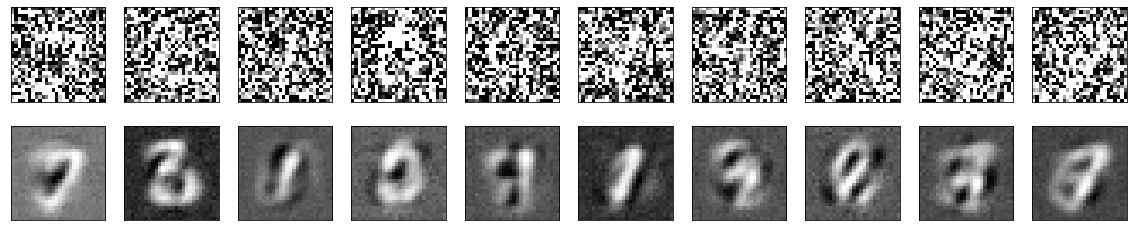

In [0]:
number = 10  
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test_noisy[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(x_test_noisy)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### **CNN BASIC MODEL**

In [2]:
#################################################################################################
#########                             CNN BASIC                                          ########
#################################################################################################

input_img = tf.keras.layers.Input(shape=(28, 28, 1)) 

# The encoder contains 3 covolutional layer and 3 max pooling layers
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# The decoder contains 3 convolutional layers and 3 up sampling layers
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0     

In [0]:
# Loading the Mnist dataset
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# Reshaping it to 28*28*1 for the CNN model
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Introducing noise with a probability factor of 0.5
noise_factor = 0.5
x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


In [0]:
autoencoder.fit(x_train_noisy, x_train, epochs=100, batch_size=128, 
                shuffle=True, validation_data=(x_test_noisy, x_test), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/100
469/469 [==============================] - 4s 8ms/step - loss: 0.6972 - val_loss: 0.6956
Epoch 2/100
469/469 [==============================] - 3s 7ms/step - loss: 0.6942 - val_loss: 0.6926
Epoch 3/100
469/469 [==============================] - 3s 7ms/step - loss: 0.6912 - val_loss: 0.6896
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.6878 - val_loss: 0.6858
Epoch 5/100
469/469 [==============================] - 3s 7ms/step - loss: 0.6823 - val_loss: 0.6774
Epoch 6/100
469/469 [==============================] - 3s 7ms/step - loss: 0.6653 - val_loss: 0.6460
Epoch 7/100
469/469 [==============================] - 3s 7ms/step - loss: 0.5926 - val_loss: 0.5167
Epoch 8/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4685 - val_loss: 0.4574
Epoch 9/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4499 - val_loss: 0.4513
Epoch 10/100
469/469 [==============================] - 3s 7ms/step - loss: 0.4444 - val_lo

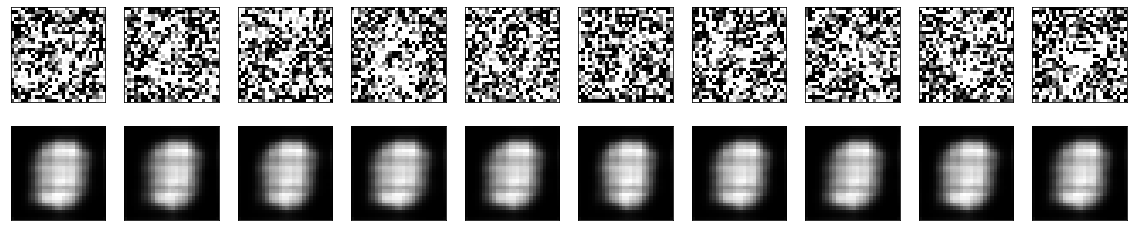

In [0]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### **CNN MODEL OPTIMIZED**

In [33]:

#################################################################################################
#########                        CNN MODEL OPTIMIZED                                     ########
#################################################################################################

input_img = tf.keras.layers.Input(shape=(28, 28, 1))

# The encoder contains 3 convolutional, 2 max pooling layers, dense layer and batch normalization after every convolutional layer 
x = tf.keras.layers.Conv2D(16, (5, 5), activation='relu', padding='same')(input_img)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (5, 5), activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(4, (5, 5), activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# The decoder contains 3 convolutional, 2 up sampling layers, dense layer and batch normalization after every convolutional layer 
x = tf.keras.layers.Conv2D(8, (5, 5), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',padding = 'same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.BatchNormalization()(x)
decoded = tf.keras.layers.Conv2D(1, (5, 5), activation='sigmoid')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
optimizer = tf.keras.optimizers.Adam(lr=0.001)
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')
autoencoder.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 28, 28, 16)        416       
_________________________________________________________________
batch_normalization_116 (Bat (None, 28, 28, 16)        64        
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 14, 14, 8)         3208      
_________________________________________________________________
batch_normalization_117 (Bat (None, 14, 14, 8)         32        
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 7, 7, 8)           0  

In [0]:
from keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Introduce noise with a probability factor of 0.5
noise_factor = 0.5
x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


In [35]:
autoencoder.fit(x_train_noisy, x_train, epochs=100, batch_size=128, 
                shuffle=True, validation_data=(x_test_noisy, x_test), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/100
469/469 [==============================] - 4s 8ms/step - loss: 0.2453 - val_loss: 0.2037
Epoch 2/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1938 - val_loss: 0.1914
Epoch 3/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1854 - val_loss: 0.1818
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1809 - val_loss: 0.1791
Epoch 5/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1782 - val_loss: 0.1766
Epoch 6/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1763 - val_loss: 0.1782
Epoch 7/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1750 - val_loss: 0.1748
Epoch 8/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1739 - val_loss: 0.1733
Epoch 9/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1729 - val_loss: 0.1725
Epoch 10/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1721 - val_lo

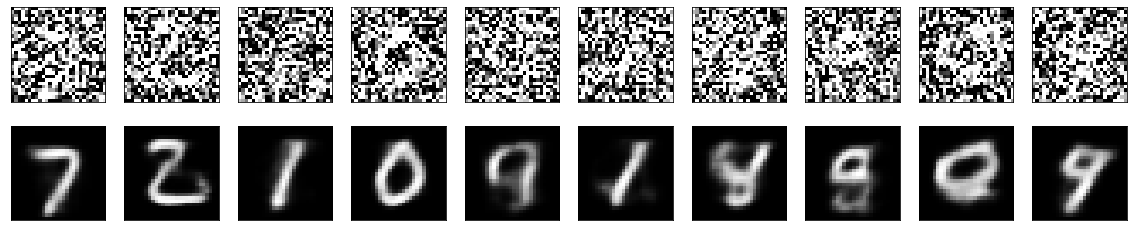

In [29]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()